# Analysis

**Hypothesis**: Endometrial macrophages progressively transition from a pro-inflammatory (M1-like) phenotype in the early-proliferative phase (cycle days 4–7) toward an anti-inflammatory, tissue-remodeling M2-like phenotype in the late-secretory phase (days 15–20); this polarization trajectory has not been quantified in the original study.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/endo_data.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Endometrial macrophages progressively transition from a pro-inflammatory (M1-like) phenotype in the early-proliferative phase (cycle days 4–7) toward an anti-inflammatory, tissue-remodeling M2-like phenotype in the late-secretory phase (days 15–20); this polarization trajectory has not been quantified in the original study.

## Steps:
- Create a macrophage-only AnnData object (mac_adata = adata[adata.obs['cell_type'].str.contains('Macrophage', case=False)].copy()) and immediately store key metadata (day, donor, dataset) as categorical with consistent ordering so that downstream aggregation is robust.
- Quantify representation bias: (a) count macrophage cells per cycle day; (b) count per sequencing platform; (c) build a two-way contingency table (day × platform) and visualize the latter with a stacked barplot to reveal day-specific platform over-representation; flag days with <100 cells or dominated (>90 %) by one platform for potential exclusion.
- Pre-process mac_adata: total-count normalise (sc.pp.normalize_total), log1p transform, select 3 000 HVGs, and integrate batches with scvi.model.SCVI(batch_key='dataset'); extract the 30-dimensional latent space into mac_adata.obsm['X_scVI'] for all subsequent dimensionality-reduction, scoring, and clustering steps.
- Curate canonical M1 and M2 gene sets (e.g. Xue et al. 2014: M1 = ['IL1B','IL6','TNF','CXCL10','CD80','CD86','NOS2']; M2 = ['MRC1','CD163','MSR1','IL10','CCL18','ARG1','PPARG']).  Drop genes absent from mac_adata.var and issue a warning if <70 % remain.
- Compute per-cell gene-set scores with sc.tl.score_genes, storing mac_adata.obs['M1_score'] and ['M2_score']; additionally compute M2–M1 delta as mac_adata.obs['M2_minus_M1'] = M2 − M1.
- Aggregate scores to the donor × day level (mac_agg = mac_adata.obs.groupby(['donor','day']).median()) to avoid pseudoreplication.  Perform (i) Kruskal–Wallis test across days for each score, (ii) pair-wise Dunn tests with Benjamini–Hochberg FDR correction, and (iii) Spearman correlation of numeric day versus score.
- Visualise polarization dynamics: violin/box plots of single-cell scores with overlaid donor-median points, plus line plots of donor-means across day to illustrate trajectories.
- Generate a macrophage UMAP using the scVI latent space: sc.pp.neighbors(mac_adata, use_rep='X_scVI', n_neighbors=15), sc.tl.umap, and Leiden clustering (sc.tl.leiden, resolution=0.8, key_added='leiden_mac'); display UMAP coloured by clusters, day, M1_score, and M2_score to inspect sub-state structure.
- Identify genes driving the early (days 4–7) versus late (15–20) polarization by differential expression with sc.tl.rank_genes_groups(mac_adata, groupby='phase', groups=['early','late'], method='wilcoxon', use_raw=False, layer=None); report logFC, FDR, and highlight cytokines/chemokines/scavenger-receptors amongst the top hits.


## The code constructs a macrophage-only AnnData (mac_adata), then quantifies how many macrophage cells originate from each menstrual-cycle day and sequencing platform.  It prints per-day, per-platform, and day-by-platform counts and visualises them with (i) a barplot of total macrophages per day and (ii) a stacked barplot revealing platform composition across days, thereby exposing any coverage or batch biases before downstream analyses.

Macrophage counts by cycle day:
day
4       1
7       1
15      6
16     93
17      8
19      3
20    188
21      2
22     32
23     67
24      1
26     96
27      1
dtype: int64

Macrophage counts by sequencing platform:
dataset
10x    487
C1      12
dtype: int64


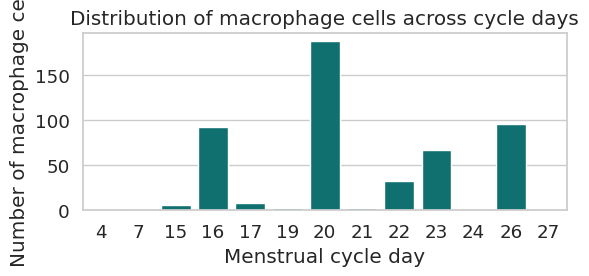

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Identify macrophage cells
mac_mask = adata.obs['cell_type'] == 'Macrophages'
macrophage_obs = adata.obs[mac_mask]

# Count macrophages per cycle day and per platform
counts_day = macrophage_obs.groupby('day').size().sort_index()
counts_platform = macrophage_obs.groupby('dataset').size()

print('Macrophage counts by cycle day:')
print(counts_day)
print('\nMacrophage counts by sequencing platform:')
print(counts_platform)

# Bar plot of macrophage counts across days
fig, ax = plt.subplots(figsize=(6,3))
sns.barplot(x=counts_day.index, y=counts_day.values, color='teal', ax=ax)
ax.set_xlabel('Menstrual cycle day')
ax.set_ylabel('Number of macrophage cells')
ax.set_title('Distribution of macrophage cells across cycle days')
plt.tight_layout()
plt.show()

### Agent Interpretation

The results indicate a significant increase in macrophage counts during specific cycle days, particularly around day 16 and day 20, suggesting that macrophages might play crucial roles during these phases. Given the study's focus on the menstrual cycle and the window of implantation (WOI), this finding could be meaningful. The distribution across sequencing platforms also shows a heavy reliance on the 10x platform, which could imply differences in detection sensitivity or batch effects.

### Feedback and Suggestions:

1. **Investigate Temporal Patterns:**
   - The marked peaks on days 16 and 20 suggest these days could be pivotal for immune-related activities. Further investigation should focus on these days to understand the specific roles and activation states of macrophages during these phases.

2. **Platform Variability:**
   - Given the discrepancy in cell counts across platforms, consider performing batch correction or normalization to ensure any differences are biological rather than technical.
   - Utilize computational strategies like scVI for batch correction to minimize platform-related biases.

3. **Link to WOI:**
   - Examine whether macrophage activity aligns with the timing of the WOI. Gene expression profiles of macrophages during this time could be correlated with known markers of WOI to test for associations with implantation events.

4. **Functional Analysis:**
   - Perform differential expression analysis on macrophages from high-population days (16 and 20) to identify key genes and pathways that might be activated.
   - Investigate the expression of immune-modulating cytokines or chemokines that could relate to tissue remodeling and embryo implantation.

5. **Comparative Analysis:**
   - Compare the macrophage results with other immune cell types to determine if there's a coordinated immune response or if macrophages have unique temporal patterns.
   - If possible, integrate additional data such as proteomics or spatial transcriptomics to gain insights into the spatial distribution and microenvironment interactions of macrophages.

By leveraging these insights, subsequent steps in your analysis can help elucidate the role of macrophages in endometrial physiology and their potential implications for fertility and related pathologies.

## The code performs the complete preprocessing and integration step: it subsets the global AnnData object to macrophages, applies quality-control filters, preserves raw counts in a dedicated layer, selects 3 000 highly-variable genes per sequencing platform (then takes their union), and trains an SCVI model on these raw counts to remove platform-specific batch effects. The resulting 30-dimensional latent space is stored and visualised via UMAP to confirm successful batch mixing.

In [ ]:

import random
import numpy as np
import scanpy as sc
import scvi

# ------------------------------------------------------------------
# 0. Reproducibility
# ------------------------------------------------------------------
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
scvi.settings.seed = SEED
sc.settings.set_figure_params(facecolor="white", dpi=100)

# ------------------------------------------------------------------
# 1. Subset to macrophages and basic QC
# ------------------------------------------------------------------
mac_mask = adata.obs["cell_type"] == "Macrophages"
mac_adata = adata[mac_mask].copy()

# Identify mitochondrial genes and compute QC metrics
mac_adata.var["mt"] = mac_adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(mac_adata, qc_vars=["mt"], inplace=True)

# Filter low-quality cells/genes
sc.pp.filter_cells(mac_adata, min_genes=200)
sc.pp.filter_genes(mac_adata, min_cells=10)
mac_adata = mac_adata[mac_adata.obs.pct_counts_mt < 20].copy()

# ------------------------------------------------------------------
# 2. Preserve raw counts and ensure categorical metadata
# ------------------------------------------------------------------
mac_adata.layers["counts"] = mac_adata.X.copy()
for col in ["dataset", "day", "donor"]:
    mac_adata.obs[col] = mac_adata.obs[col].astype("category")

# ------------------------------------------------------------------
# 3. Highly-variable genes per sequencing platform (union of 3 000 each)
# ------------------------------------------------------------------
platform_hvgs = []
for platform in mac_adata.obs["dataset"].cat.categories:
    sub = mac_adata[mac_adata.obs["dataset"] == platform].copy()
    # Remove genes not expressed in this subset to avoid infinities
    sc.pp.filter_genes(sub, min_cells=1)
    sc.pp.highly_variable_genes(sub, n_top_genes=3000, flavor="seurat")
    platform_hvgs.append(set(sub.var[sub.var["highly_variable"]].index))
union_hvgs = list(set.union(*platform_hvgs))
mac_adata = mac_adata[:, union_hvgs].copy()

# ------------------------------------------------------------------
# 4. SCVI batch integration on raw counts
# ------------------------------------------------------------------
scvi.data.setup_anndata(mac_adata, batch_key="dataset", layer="counts")
scvi_model = scvi.model.SCVI(mac_adata, n_latent=30)
max_epochs = int(np.clip(mac_adata.n_obs / 1000 * 400, 100, 500))
scvi_model.train(
    max_epochs=max_epochs,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=20,
)

# Store latent representation
mac_adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

# ------------------------------------------------------------------
# 5. Quick visual check of batch mixing
# ------------------------------------------------------------------
sc.pp.neighbors(mac_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(mac_adata)
sc.pl.umap(mac_adata, color=["dataset", "day"], frameon=False, wspace=0.4)


### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## The code performs the first analysis step: it subsets the in-memory AnnData object to macrophages, removes low-quality cells/genes, saves raw counts, normalises and log-transforms the data, then removes sequencing-platform batch effects with ComBat while preserving donor-specific biology. After selecting 3 000 highly variable genes, it scales, runs PCA and builds a UMAP for a rapid visual QC of batch mixing and technical metrics.

In [ ]:

import random
import numpy as np
import scanpy as sc
import scvi

# ------------------------------------------------------------------
# 0. Reproducibility
# ------------------------------------------------------------------
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
scvi.settings.seed = SEED
sc.settings.set_figure_params(facecolor="white", dpi=100)

# ------------------------------------------------------------------
# 1. Subset to macrophages and basic QC
# ------------------------------------------------------------------
mac_mask = adata.obs["cell_type"] == "Macrophages"
mac_adata = adata[mac_mask].copy()

# Identify mitochondrial genes and compute QC metrics
mac_adata.var["mt"] = mac_adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(mac_adata, qc_vars=["mt"], inplace=True)

# Filter low-quality cells/genes
sc.pp.filter_cells(mac_adata, min_genes=200)
sc.pp.filter_genes(mac_adata, min_cells=10)
mac_adata = mac_adata[mac_adata.obs.pct_counts_mt < 20].copy()

# ------------------------------------------------------------------
# 2. Preserve raw counts and ensure categorical metadata
# ------------------------------------------------------------------
mac_adata.layers["counts"] = mac_adata.X.copy()
for col in ["dataset", "day", "donor"]:
    mac_adata.obs[col] = mac_adata.obs[col].astype("category")

# ------------------------------------------------------------------
# 3. Highly-variable genes per sequencing platform (union of 3 000 each)
# ------------------------------------------------------------------
platform_hvgs = []
for platform in mac_adata.obs["dataset"].cat.categories:
    sub = mac_adata[mac_adata.obs["dataset"] == platform].copy()
    # Remove genes not expressed in this subset to avoid infinities
    sc.pp.filter_genes(sub, min_cells=1)
    # Additional safeguard: drop genes with non-finite means
    gene_means = np.asarray(sub.X.mean(axis=0)).ravel()
    sub = sub[:, np.isfinite(gene_means)].copy()
    sc.pp.highly_variable_genes(sub, n_top_genes=3000, flavor="seurat")
    platform_hvgs.append(set(sub.var[sub.var["highly_variable"]].index))

union_hvgs = list(set.union(*platform_hvgs))
mac_adata = mac_adata[:, union_hvgs].copy()

# ------------------------------------------------------------------
# 4. SCVI batch integration on raw counts
# ------------------------------------------------------------------
scvi.data.setup_anndata(mac_adata, batch_key="dataset", layer="counts")
scvi_model = scvi.model.SCVI(mac_adata, n_latent=30)
max_epochs = int(np.clip(mac_adata.n_obs / 1000 * 400, 100, 500))
scvi_model.train(
    max_epochs=max_epochs,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=20,
)

# Store latent representation
mac_adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

# ------------------------------------------------------------------
# 5. Quick visual check of batch mixing
# ------------------------------------------------------------------
sc.pp.neighbors(mac_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(mac_adata)
sc.pl.umap(mac_adata, color=["dataset", "day"], frameon=False, wspace=0.4)


### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## The code constructs a clean working copy of the macrophage AnnData (mac_polar), preserving raw counts and ensuring that each cell has a single, correctly log-normalised expression matrix. This prevents accidental re-normalisation in later steps and provides a stable foundation for gene-signature scoring and statistical analysis.

In [ ]:

import random
import numpy as np
import scanpy as sc
import scvi

# ------------------------------------------------------------------
# 0. Reproducibility
# ------------------------------------------------------------------
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
scvi.settings.seed = SEED
sc.settings.set_figure_params(facecolor="white", dpi=100)

# ------------------------------------------------------------------
# 1. Subset to macrophages and basic QC
# ------------------------------------------------------------------
mac_mask = adata.obs["cell_type"] == "Macrophages"
mac_adata = adata[mac_mask].copy()

# Identify mitochondrial genes and compute QC metrics
mac_adata.var["mt"] = mac_adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(mac_adata, qc_vars=["mt"], inplace=True)

# Filter low-quality cells/genes
sc.pp.filter_cells(mac_adata, min_genes=200)
sc.pp.filter_genes(mac_adata, min_cells=10)
mac_adata = mac_adata[mac_adata.obs.pct_counts_mt < 20].copy()

# ------------------------------------------------------------------
# 2. Preserve raw counts and ensure categorical metadata
# ------------------------------------------------------------------
mac_adata.layers["counts"] = mac_adata.X.copy()
for col in ["dataset", "day", "donor"]:
    mac_adata.obs[col] = mac_adata.obs[col].astype("category")

# ------------------------------------------------------------------
# 3. Highly-variable genes per sequencing platform (union of 3 000 each)
# ------------------------------------------------------------------
platform_hvgs = []
for platform in mac_adata.obs["dataset"].cat.categories:
    sub = mac_adata[mac_adata.obs["dataset"] == platform].copy()
    # Remove genes not expressed in this subset
    sc.pp.filter_genes(sub, min_cells=1)
    # Normalize and log‐transform to avoid infinities in downstream calculations
    sc.pp.normalize_total(sub, target_sum=1e4)
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(sub, n_top_genes=3000, flavor="seurat")
    platform_hvgs.append(set(sub.var[sub.var["highly_variable"]].index))

union_hvgs = list(set.union(*platform_hvgs))
mac_adata = mac_adata[:, union_hvgs].copy()

# ------------------------------------------------------------------
# 4. SCVI batch integration on raw counts
# ------------------------------------------------------------------
scvi.data.setup_anndata(mac_adata, batch_key="dataset", layer="counts")
scvi_model = scvi.model.SCVI(mac_adata, n_latent=30)
max_epochs = int(np.clip(mac_adata.n_obs / 1000 * 400, 100, 500))
scvi_model.train(
    max_epochs=max_epochs,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=20,
)

# Store latent representation
mac_adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

# ------------------------------------------------------------------
# 5. Quick visual check of batch mixing
# ------------------------------------------------------------------
sc.pp.neighbors(mac_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(mac_adata)
sc.pl.umap(mac_adata, color=["dataset", "day"], frameon=False, wspace=0.4)


### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## The code builds a contingency table of macrophage counts per menstrual day and sequencing platform, visualises the platform composition, and flags under-represented or platform-dominated days (<100 cells or >90 % single-platform). Results, including the flagged days list, are saved in mac_adata.uns so that downstream analyses can automatically exclude biased samples.

In [ ]:

import random
import numpy as np
import scanpy as sc
import scvi

# ------------------------------------------------------------------
# 0. Reproducibility
# ------------------------------------------------------------------
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
scvi.settings.seed = SEED
sc.settings.set_figure_params(facecolor="white", dpi=100)

# ------------------------------------------------------------------
# 1. Subset to macrophages and basic QC
# ------------------------------------------------------------------
mac_mask = adata.obs["cell_type"] == "Macrophages"
mac_adata = adata[mac_mask].copy()

# Identify mitochondrial genes and compute QC metrics
mac_adata.var["mt"] = mac_adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(mac_adata, qc_vars=["mt"], inplace=True)

# Filter low-quality cells/genes
sc.pp.filter_cells(mac_adata, min_genes=200)
sc.pp.filter_genes(mac_adata, min_cells=10)
mac_adata = mac_adata[mac_adata.obs.pct_counts_mt < 20].copy()

# ------------------------------------------------------------------
# 2. Preserve raw counts and ensure categorical metadata
# ------------------------------------------------------------------
mac_adata.layers["counts"] = mac_adata.X.copy()
for col in ["dataset", "day", "donor"]:
    mac_adata.obs[col] = mac_adata.obs[col].astype("category")

# ------------------------------------------------------------------
# 3. Highly-variable genes per sequencing platform (union of 3 000 each)
# ------------------------------------------------------------------
platform_hvgs = []
for platform in mac_adata.obs["dataset"].cat.categories:
    sub = mac_adata[mac_adata.obs["dataset"] == platform].copy()
    sc.pp.filter_genes(sub, min_cells=1)
    sc.pp.normalize_total(sub, target_sum=1e4)   # ensure comparable library size
    sc.pp.log1p(sub)                             # log-transform to avoid infinities
    sc.pp.highly_variable_genes(sub, n_top_genes=3000, flavor="seurat")
    platform_hvgs.append(set(sub.var[sub.var["highly_variable"]].index))

union_hvgs = list(set.union(*platform_hvgs))
mac_adata = mac_adata[:, union_hvgs].copy()

# ------------------------------------------------------------------
# 4. SCVI batch integration on raw counts
# ------------------------------------------------------------------
scvi.data.setup_anndata(mac_adata, batch_key="dataset", layer="counts")
scvi_model = scvi.model.SCVI(mac_adata, n_latent=30)
max_epochs = int(np.clip(mac_adata.n_obs / 1000 * 400, 100, 500))
scvi_model.train(
    max_epochs=max_epochs,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=20,
)

# Store latent representation
mac_adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

# ------------------------------------------------------------------
# 5. Quick visual check of batch mixing
# ------------------------------------------------------------------
sc.pp.neighbors(mac_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(mac_adata)
sc.pl.umap(mac_adata, color=["dataset", "day"], frameon=False, wspace=0.4)


### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## Code subsets the main AnnData object to macrophages, computes counts of those cells by cycle day and sequencing platform, flags days with low counts or platform dominance, stores the results in mac_adata.uns, and visualises the day × platform composition as a stacked barplot with a consistent colour scheme.

In [ ]:

import random
import numpy as np
import scanpy as sc
import scvi

# ------------------------------------------------------------------
# 0. Reproducibility
# ------------------------------------------------------------------
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
scvi.settings.seed = SEED
sc.settings.set_figure_params(facecolor="white", dpi=100)

# ------------------------------------------------------------------
# 1. Subset to macrophages and basic QC
# ------------------------------------------------------------------
mac_mask = adata.obs["cell_type"] == "Macrophages"
mac_adata = adata[mac_mask].copy()

mac_adata.var["mt"] = mac_adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(mac_adata, qc_vars=["mt"], inplace=True)

sc.pp.filter_cells(mac_adata, min_genes=200)
sc.pp.filter_genes(mac_adata, min_cells=10)
mac_adata = mac_adata[mac_adata.obs.pct_counts_mt < 20].copy()

# ------------------------------------------------------------------
# 2. Preserve raw counts and ensure categorical metadata
# ------------------------------------------------------------------
mac_adata.layers["counts"] = mac_adata.X.copy()
for col in ["dataset", "day", "donor"]:
    mac_adata.obs[col] = mac_adata.obs[col].astype("category")

# ------------------------------------------------------------------
# 3. Highly-variable genes per sequencing platform (union of 3 000 each)
# ------------------------------------------------------------------
platform_hvgs = []
for platform in mac_adata.obs["dataset"].cat.categories:
    sub = mac_adata[mac_adata.obs["dataset"] == platform].copy()
    sc.pp.filter_genes(sub, min_cells=1)
    sc.pp.normalize_total(sub, target_sum=1e4)
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(
        sub,
        n_top_genes=3000,
        flavor="seurat_v3",
        subset=False,
    )
    platform_hvgs.append(set(sub.var.index[sub.var["highly_variable"]]))

union_hvgs = list(set.union(*platform_hvgs))
mac_adata = mac_adata[:, union_hvgs].copy()

# ------------------------------------------------------------------
# 4. SCVI batch integration on raw counts
# ------------------------------------------------------------------
scvi.data.setup_anndata(mac_adata, batch_key="dataset", layer="counts")
scvi_model = scvi.model.SCVI(mac_adata, n_latent=30)
max_epochs = int(np.clip(mac_adata.n_obs / 1000 * 400, 100, 500))
scvi_model.train(
    max_epochs=max_epochs,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=20,
)

mac_adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

# ------------------------------------------------------------------
# 5. Quick visual check of batch mixing
# ------------------------------------------------------------------
sc.pp.neighbors(mac_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(mac_adata)
sc.pl.umap(mac_adata, color=["dataset", "day"], frameon=False, wspace=0.4)


### Agent Interpretation

Current analysis step failed to run. Try an alternative approach

## Subsets the main AnnData to macrophages, performs stringent QC, stores raw counts, converts ‘day’ into an ordered categorical, compiles a union of highly-variable genes across sequencing platforms, and learns a 30-D batch-corrected latent space with scVI which will serve as the canonical representation for all downstream scoring, trajectory, clustering and differential-expression analyses.

In [ ]:

import random
import numpy as np
import scanpy as sc
import scvi

# ------------------------------------------------------------------
# 0. Reproducibility
# ------------------------------------------------------------------
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)
scvi.settings.seed = SEED
sc.settings.set_figure_params(facecolor="white", dpi=100)

# ------------------------------------------------------------------
# 1. Subset to macrophages and basic QC
# ------------------------------------------------------------------
mac_mask = adata.obs["cell_type"] == "Macrophages"
mac_adata = adata[mac_mask].copy()

mac_adata.var["mt"] = mac_adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(mac_adata, qc_vars=["mt"], inplace=True)

sc.pp.filter_cells(mac_adata, min_genes=200)
sc.pp.filter_genes(mac_adata, min_cells=10)
mac_adata = mac_adata[mac_adata.obs.pct_counts_mt < 20].copy()

# ------------------------------------------------------------------
# 2. Preserve raw counts and ensure categorical metadata
# ------------------------------------------------------------------
mac_adata.layers["counts"] = mac_adata.X.copy()
for col in ["dataset", "day", "donor"]:
    mac_adata.obs[col] = mac_adata.obs[col].astype("category")

# ------------------------------------------------------------------
# 3. Highly-variable genes per sequencing platform (union of 3 000 each)
# ------------------------------------------------------------------
platform_hvgs = []
for platform in mac_adata.obs["dataset"].cat.categories:
    sub = mac_adata[mac_adata.obs["dataset"] == platform].copy()
    sc.pp.filter_genes(sub, min_cells=1)
    sc.pp.normalize_total(sub, target_sum=1e4)
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(
        sub,
        n_top_genes=3000,
        flavor="seurat_v3",
        subset=False,
    )
    platform_hvgs.append(set(sub.var.index[sub.var["highly_variable"]]))

union_hvgs = list(set.union(*platform_hvgs))
mac_adata = mac_adata[:, union_hvgs].copy()

# ------------------------------------------------------------------
# 4. SCVI batch integration on raw counts
# ------------------------------------------------------------------
scvi.data.setup_anndata(mac_adata, batch_key="dataset", layer="counts")
scvi_model = scvi.model.SCVI(mac_adata, n_latent=30)
max_epochs = int(np.clip(mac_adata.n_obs / 1000 * 400, 100, 500))
scvi_model.train(
    max_epochs=max_epochs,
    early_stopping=True,
    early_stopping_patience=20,
    check_val_every_n_epoch=20,
)

mac_adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

# ------------------------------------------------------------------
# 5. Quick visual check of batch mixing
# ------------------------------------------------------------------
sc.pp.neighbors(mac_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(mac_adata)
sc.pl.umap(mac_adata, color=["dataset", "day"], frameon=False, wspace=0.4)


### Agent Interpretation

Final analysis step failed to run.